In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from tensorflow.keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout,Add,BatchNormalization,ReLU,Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from matplotlib.image import imread

ModuleNotFoundError: No module named 'keras'

In [91]:
from skimage.io import imread
from skimage.color import rgb2lab, lab2rgb

In [92]:
proj_path = 'C:/Users/patel/Desktop/image_editing/data'

In [93]:
import re
from tqdm import tqdm
from keras.preprocessing.image import img_to_array,load_img
SIZE = 128
#SIZE64 = 64
color_img = []
gray_img = []
path = [proj_path+'/train_data/']
for fold_path in path:
    files = os.listdir(fold_path)
    
    for i in tqdm(files):
        if i=='.DS_Store':
            print(fold_path+i)
            continue
        try:
            img = cv2.imread(fold_path+i,1)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray = cv2.resize(gray, (SIZE, SIZE))
            gray = gray.astype('float32') / 255.0
            gray_img.append(img_to_array(gray))
            
            color_img.append(img_to_array(load_img(fold_path+i,target_size=(SIZE,SIZE))))
        except:
            print('error')
    print(fold_path,"completed")

100%|████████████████████████████████████████████████████████████████████████████| 10145/10145 [02:39<00:00, 63.50it/s]

C:/Users/patel/Desktop/image_editing/data/train_data/ completed


In [94]:
len(gray_img)

10145

In [95]:
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color/255.0)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(np.squeeze(grayscale), cmap='Greys_r')
   
    plt.show()

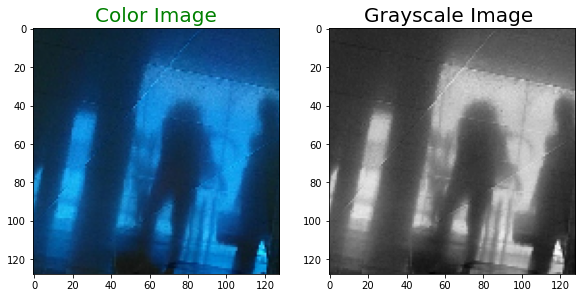

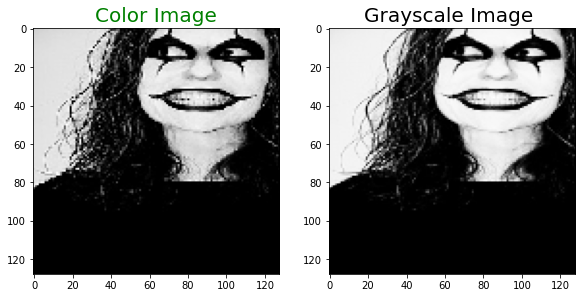

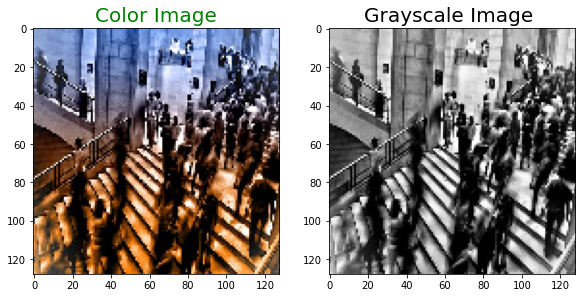

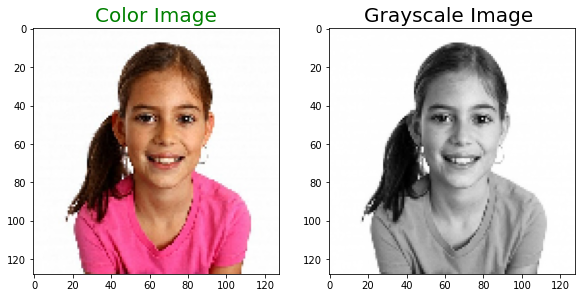

In [96]:
for i in range(-5,-1):
     plot_images(color_img[i],gray_img[i])

In [97]:
from skimage.color import rgb2lab, lab2rgb
color_img = np.array(color_img)
if color_img.max()>1.0:
    color_img = color_img/255.0
    Xsub_lab = rgb2lab(np.array(color_img))

In [98]:
Xsub_lab_rgb = np.zeros( Xsub_lab.shape)
for i in tqdm(range(Xsub_lab.shape[0])):
    Xsub_lab_rgb[i] = lab2rgb(Xsub_lab[i])

100%|████████████████████████████████████████████████████████████████████████████| 10145/10145 [02:05<00:00, 80.55it/s]


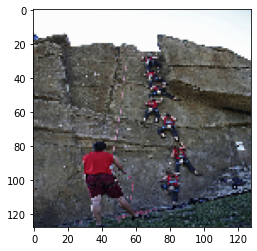

In [99]:
plt.imshow(Xsub_lab_rgb[12])

In [100]:
lab1_img = np.zeros((len(gray_img), SIZE, SIZE,2))
for i in tqdm(range(len(Xsub_lab))):
    for j in range(len(Xsub_lab[i])):
        for k in range(len(Xsub_lab[i][j])):
            lab1_img[i][j][k][0] = (Xsub_lab[i][j][k][1]+127)/255.0
            lab1_img[i][j][k][1] = (Xsub_lab[i][j][k][2]+127)/255.0

100%|████████████████████████████████████████████████████████████████████████████| 10145/10145 [33:48<00:00,  5.00it/s]


In [101]:
SIZE=128
train_gray_image = np.array(gray_img)
train_color_image = lab1_img

train_g = np.reshape(train_gray_image,(len(train_gray_image), SIZE, SIZE,1))
train_c = np.reshape(train_color_image, (len(train_color_image), SIZE, SIZE,2))
print('Train gray image shape:',train_g.shape)
print('Train color image shape:',train_c.shape)

Train gray image shape: (10145, 128, 128, 1)
Train color image shape: (10145, 128, 128, 2)


In [102]:
from tensorflow.keras import layers
autoEncode3 = Sequential()
autoEncode3.add(layers.InputLayer(input_shape=(SIZE, SIZE, 1)))
autoEncode3.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
autoEncode3.add(layers.BatchNormalization())
autoEncode3.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
autoEncode3.add(layers.BatchNormalization())
autoEncode3.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
autoEncode3.add(layers.BatchNormalization())
autoEncode3.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
autoEncode3.add(layers.BatchNormalization())
autoEncode3.add(Conv2D(512, (3, 3), activation='relu', padding='same', strides=2))
autoEncode3.add(tf.keras.layers.Flatten())
autoEncode3.add(tf.keras.layers.Reshape((4, 4, 512)))
autoEncode3.add(layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same', strides=2))
autoEncode3.add(layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2))
autoEncode3.add(layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2))
autoEncode3.add(layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2))
autoEncode3.add(layers.Conv2DTranspose(2, (3, 3), activation='relu', padding='same', strides=2))
print(autoEncode3.output_shape)

(None, 128, 128, 2)


In [105]:
autoEncode3.compile(optimizer='adam',loss='mse', metrics = ['acc'])

autoEn3_History = autoEncode3.fit(train_g, train_c, epochs = 200,batch_size = 10,verbose = 1)

Epoch 1/200
1015/1015 [==============================] - 32s 31ms/step - loss: 0.0024 - acc: 0.6565
Epoch 2/200
1015/1015 [==============================] - 39s 39ms/step - loss: 0.0022 - acc: 0.6709 2s - loss - ETA: 1s - loss: 0.00
Epoch 3/200
1015/1015 [==============================] - 46s 45ms/step - loss: 0.0020 - acc: 0.6850
Epoch 4/200
1015/1015 [==============================] - 51s 50ms/step - loss: 0.0019 - acc: 0.6937 0s - loss: 0.0019
Epoch 5/200
1015/1015 [==============================] - 52s 51ms/step - loss: 0.0018 - acc: 0.7024
Epoch 6/200
1015/1015 [==============================] - 56s 55ms/step - loss: 0.0017 - acc: 0.7079 0s - loss: 0.001
Epoch 7/200
1015/1015 [==============================] - 83s 82ms/step - loss: 0.0016 - acc: 0.7151 0s - loss: 0.0016 - ac
Epoch 8/200
1015/1015 [==============================] - 62s 61ms/step - loss: 0.0015 - acc: 0.7203
Epoch 9/200
1015/1015 [==============================] - 52s 51ms/step - loss: 0.0015 - acc: 0.7237
Epoch 10/

KeyboardInterrupt: 

In [126]:
autoEncode3.save(proj_path+'/trained_models/ResNET')

INFO:tensorflow:Assets written to: C:/Users/patel/Desktop/image_editing/data/trained_models/ResNET\assets


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


C:/Users/patel/Desktop/image_editing/data/test_data/ completed
Test color image shape (5, 128, 128, 3)
Test gray64 image shape (5, 64, 64, 1)
Test gray128 image shape (5, 128, 128, 1)


100%|███████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 252.04it/s]


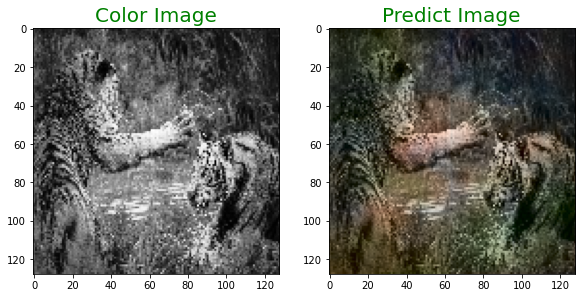

100%|███████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 254.53it/s]


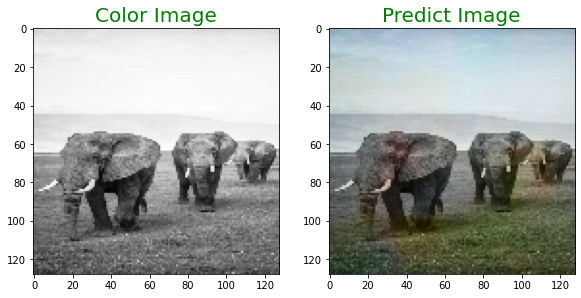

100%|███████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 247.34it/s]


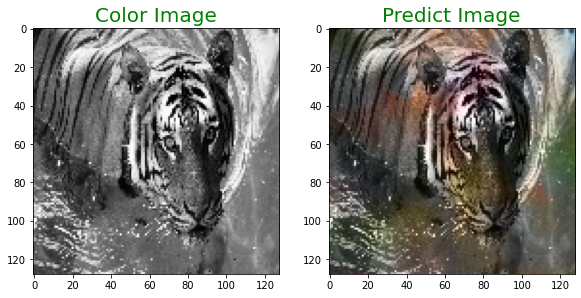

100%|███████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 236.09it/s]


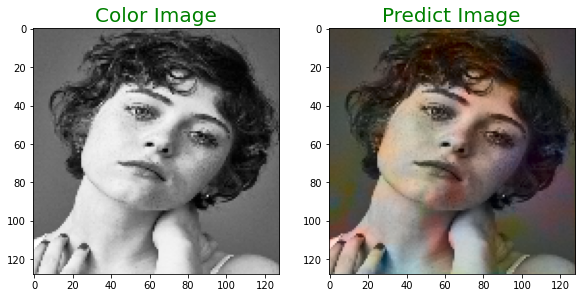

100%|███████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 235.71it/s]


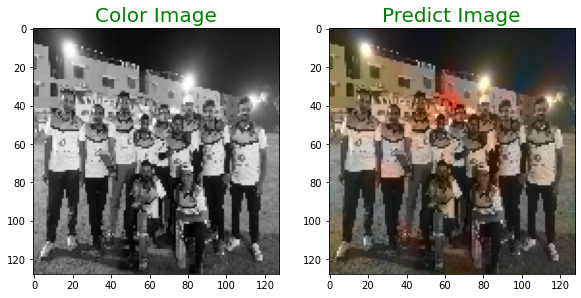

In [107]:
SIZE = 128
SIZE64 = 64
test_color_image22 = []
test_gray_image22_128 = []
test_gray_image22_64 = []
path = [proj_path+'/test_data/']
for fold_path in path:
    files = os.listdir(fold_path)
    for i in tqdm(files):
        if i=='.DS_Store':
            print(fold_path+i)
            continue
        img = cv2.imread(fold_path+i,1)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        test_color_image22.append(img_to_array(img))

        gray64 = cv2.resize(gray, (SIZE64, SIZE64))
        gray64 = gray64.astype('float32') / 255.0
        test_gray_image22_64.append(img_to_array(gray64))
        
        gray128 = cv2.resize(gray, (SIZE, SIZE))
        gray128 = gray128.astype('float32') / 255.0
        test_gray_image22_128.append(img_to_array(gray128))
    print(fold_path,"completed")
    

test_gray_image22_64 = np.reshape(test_gray_image22_64,(len(test_gray_image22_64),SIZE64,SIZE64,1))
test_gray_image22_128 = np.reshape(test_gray_image22_128,(len(test_gray_image22_128),SIZE,SIZE,1))
test_color_image22 = np.reshape(test_color_image22, (len(test_color_image22),SIZE,SIZE,3))
print('Test color image shape',test_color_image22.shape)
print('Test gray64 image shape',test_gray_image22_64.shape)
print('Test gray128 image shape',test_gray_image22_128.shape)

def plot_images(grayscale64,color128):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(np.squeeze(grayscale64), cmap='Greys_r')
    plt.subplot(1,3,2)
    plt.title('Predict Image', color = 'green', fontsize = 20)
    plt.imshow(color128)
    plt.show()
    
for i in range(0,5):
    predicted = autoEncode3.predict(test_gray_image22_128[i].reshape(1, SIZE, SIZE,1)).reshape(SIZE, SIZE,2)
    predicted2 = np.zeros((SIZE,SIZE,3))
    for j in tqdm(range(SIZE)):
        for k in range(SIZE):
            predicted2[j][k][0] = test_gray_image22_128[i][j][k][0]*100
            predicted2[j][k][1] = (predicted[j][k][0]*255)-128
            predicted2[j][k][2] = (predicted[j][k][1]*255)-128
    #print(train_c[i].shape)
    #predicted3 = np.array(lab2rgb(predicted2))
    #final_predict = Restorer1.predict(predicted3.reshape(1, SIZE64, SIZE64,3)).reshape(SIZE, SIZE,3)
    plot_images(test_gray_image22_128[i], lab2rgb(predicted2))

In [118]:
from tensorflow import Tensor
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def down_block(x: Tensor, filters: int) -> Tensor:
    y = Conv2D(kernel_size=3,
               strides= 1,
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Dropout(0.1)(y)
    y = Conv2D(kernel_size=3,
               strides=1,
               filters=filters,
               padding="same")(y)
    y = relu_bn(y)
    return y

def up_block(x: Tensor, C0: Tensor, filters: int) -> Tensor:
    y = UpSampling2D(size=(2,2))(x)
    y = Concatenate()([y, C0])
    y = Conv2D(kernel_size=3,
               strides= 1,
               filters=filters,
               padding="same")(y)
    y = ReLU()(y)
    y = Dropout(0.1)(y)
    y = Conv2D(kernel_size=3,
               strides= 1,
               filters=filters,
               padding="same")(y)
    y = ReLU()(y)
    return y

In [119]:
from tensorflow.keras.layers import MaxPooling2D,Concatenate
def model_build_UNet():
    inputs = Input(shape= [128,128,1])
    d1 = down_block(inputs, filters=64)
    d2 = MaxPooling2D(pool_size=(2, 2))(d1) 
    d2 = down_block(d2, filters=128)
    d3 = MaxPooling2D(pool_size=(2, 2))(d2) 
    d3 = down_block(d3, filters=256)
    d4 = MaxPooling2D(pool_size=(2, 2))(d3) 
    d4 = down_block(d4, filters=512)
    d5 = MaxPooling2D(pool_size=(2, 2))(d4) 
    d5 = down_block(d5, filters=1024)
    
    #upsampling
    u1 = up_block(d5,d4,filters=512)
    u2 = up_block(u1,d3,filters=256)
    u3 = up_block(u2,d2,filters=128)
    u4 = up_block(u3,d1,filters=64)
    output = Conv2D(kernel_size=3,strides= 1,filters=2,padding="same")(u4)

    return tf.keras.Model(inputs=inputs, outputs=output)

In [120]:
model_UNet=model_build_UNet()
print(model_UNet.output_shape)
model_UNet.summary()

(None, 128, 128, 2)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_92 (Conv2D)              (None, 128, 128, 64) 640         input_11[0][0]                   
__________________________________________________________________________________________________
re_lu_49 (ReLU)                 (None, 128, 128, 64) 0           conv2d_92[0][0]                  
__________________________________________________________________________________________________
batch_normalization_77 (BatchNo (None, 128, 128, 64) 256         re_lu_49[0][0]                   
________________________________________________________________________

In [121]:
model_UNet.compile(optimizer='adam',loss='mse', metrics = ['acc'])

In [ ]:
UNet_History = model_UNet.fit(train_g, train_c, epochs = 50,batch_size = 8,verbose = 1)

Epoch 1/50
 188/1269 [===>..........................] - ETA: 20:55 - loss: 0.0091 - acc: 0.5353

In [ ]:
|